# Spatially varying parameters

## Objectives

The main objective of this tutorial is to demonstrate how spatially varying parameters can be used to model and simulate different geometries and/or materials using JOOMMF.

## Problem specification

The geometry is a **cylinder** with

- radius $r = 50 \,\text{nm}$ and
- height $h = 100 \,\text{nm}$.

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics are governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = \underbrace{-\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff})}_\text{precession} + \underbrace{\alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)}_\text{damping}$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and Gilbert damping $\alpha=0.5$.

We are interested in computing the equlibrium magnetisation state starting from the uniform magnetisation in the $(1, 1, 1)$ direction.

## Simulation

In the first step, we import the required `discretisedfield` and `oommfc` modules.

In [1]:
import hublib.use
%use oommf-1.2b0

import oommfc as oc
import discretisedfield as df

We need to define the rectangular finite difference mesh that can contain the entire sphere.

In [2]:
L = 100e-9  # mesh edge length (m)
d = 5e-9  # discretisation cell (m)
mesh = oc.Mesh(p1=(0, 0, 0), p2=(L, L, L), cell=(d, d, d))

To illustrate the mesh and discretisation cell:

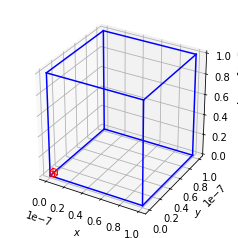

In [3]:
%matplotlib inline
mesh

As usual, we create the system object and define its Hamiltonian and dynamics equation.

In [4]:
#System object
system = oc.System(name="cylinder")

# Hamiltonian
A = 1.3e-11  # exchange energy constant (J/m)
H = (0, 0, 0.2e-3/oc.mu0)  # external magnetic field (A/m)
system.hamiltonian = oc.Exchange(A) + oc.Demag() + oc.Zeeman(H)

# Dynamics
gamma = 2.211e5
alpha = 0.5
system.dynamics = oc.Precession(gamma) + oc.Damping(alpha)

The Hamiltonian and dynamics equation are:

In [5]:
system.hamiltonian

Exchange(A=1.3e-11, name="exchange") + Demag(name="demag") + Zeeman(H=(0, 0, 159.15494309189535), name="zeeman")

In [6]:
system.dynamics

Precession(gamma=221100.0, name="precession") + Damping(alpha=0.5, name="damping")

### Defining cylinder geometry

In order to define cylinder geometry inside the rectangular mesh, we can define the saturation magnetisation function (we name it `Ms_function`), which depending on the position inside mesh $pos = (x, y, z)$ returns $M_\text{s}$ if the point is inside the culinder and $0$ otherwise:

$$
M_\text{s} =
  \begin{cases}
    8 \times 10^{5}, & \sqrt{x^{2} + y^{2}} \leq 50\,\text{nm} \\
    0, & \sqrt{x^{2} + y^{2}} > 50\,\text{nm}. \\
  \end{cases}
$$

In [7]:
import math

def Ms_function(pos):
    x, y, z = pos
    r = math.sqrt((x-L/2)**2 + (y-L/2)**2)
    if r <= 50e-9:
        return 8e5
    else:
        return 0

Having the function defining the sphere geometry, we can now create the initial magnetisation field. The value of field should be the inital magnetisation $(1, 0, 0)$ and the norm should be the saturation magnetisation function we just created.

In [8]:
system.m = df.Field(mesh, value=(1, 1, 1), norm=Ms_function)

We can plot the initial magnetisation by slicing the cylinder geometry perpendicular to "z" and "x" axes.

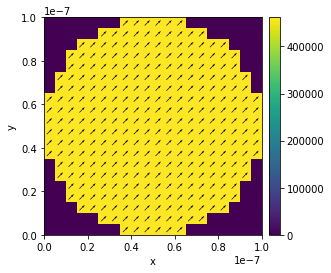

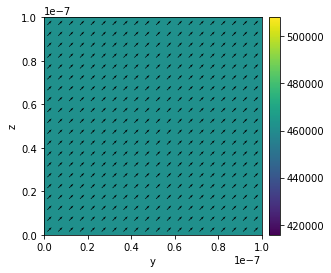

In [9]:
system.m.plot_plane("z")
system.m.plot_plane("x")

### Relaxing the magnetisation

After we defined all requited parameters of the system, we can relax the system using `MinDriver`.

In [10]:
td = oc.MinDriver()
td.drive(system)

2017/11/20 18:30: Calling OOMMF (cylinder/cylinder.mif) ... [4.2s]


And plot the magnetisation in the same slices as before.

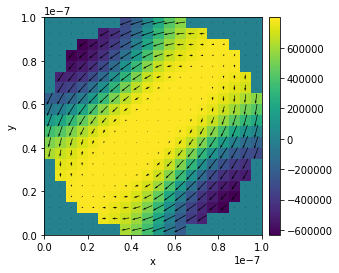

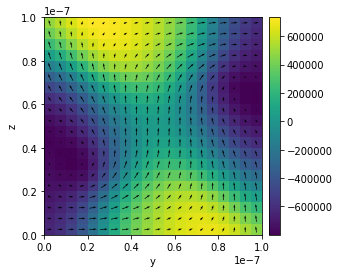

In [11]:
system.m.plot_plane("z")
system.m.plot_plane("x")

<hr>
Cleaning up.  Temporary files were written.  You may want to remove them.

In [12]:
!rm -rf cylinder